# Phishing email detection
**Chloé MIGAUD, Dan'ella Sara Océane SOSSOU, Aya TEGUIA**  

**Dataset:** [Kaggle — Phishing Email Dataset](https://www.kaggle.com/datasets/subhajournal/phishingemails)  
**GitHub repository:** https://github.com/chloe786/phishing-email-detection_OCC3

**Goal:** This notebook presents the full pipeline for detecting phishing emails using machine learning. 
It includes data preprocessing, TF-IDF vectorization, baseline models, hyperparameter tunin, and ensemble methods.

**Problem formalization** : How can we automatically detect phishing emails using Machine Learning?  
The goal is to create a model that looks at the text of an email and predicts if it’s Safe or Phishing. This helps make email systems safer and protect users from scams.

So this is a supervised binary classification problem where the goal is to classify each email as Safe or Phishing based on its content.

In [55]:
# --- 0) Imports ---
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt


### Part 1 : Data loading and cleaning
In this first part, we load the dataset, inspect its structure and clean missing or empty email texts.


In [12]:
# --- Descriptive analysis of the data ---
# Load of the dataset 
df = pd.read_csv("Phishing_Email.csv")

# We only kept the relevant columns and dropt missing values
df = df[['Email Text', 'Email Type']].dropna()

display(df.head())

# Basic info
print("\nDataset info:")
print(df.info())

# Class distribution
print("\nClass distribution:")
print(df['Email Type'].value_counts())

# Simple length statistic (to see how long are the emails)
df['text_len'] = df['Email Text'].str.len()
print("\nEmail length (chars):")
print(df['text_len'].describe())

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email



Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18634 non-null  object
dtypes: object(2)
memory usage: 436.7+ KB
None

Class distribution:
Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

Email length (chars):
count    1.863400e+04
mean     2.755654e+03
std      1.248677e+05
min      1.000000e+00
25%      4.040000e+02
50%      8.815000e+02
75%      1.880000e+03
max      1.703669e+07
Name: text_len, dtype: float64


We kept 2 main columns: Email Text (contains the raw message) and Email Type (Safe or Phishin). Then we removed missing values to make sure the dataset was clean. The class distribution shows there are more Safe Emails than Phishing Emails, this is common in this type of dataset.  

The text length varies a lot, some emails are very short, others extremely long. The dataset is quite diverse. This first look helps us understand the data and what to expect before moving to preprocessing and modeling.

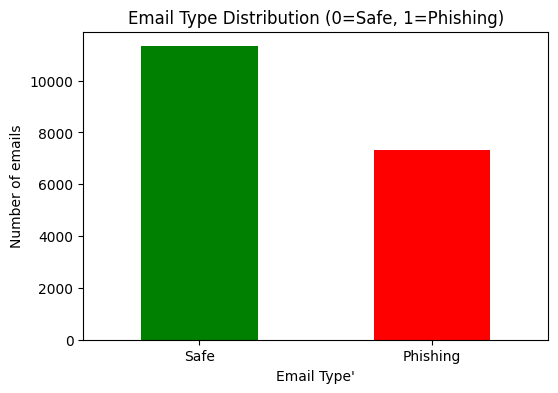

In [5]:
# Plot class distribution
plt.figure(figsize=(6, 4))
df["Email Type"].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Email Type Distribution (0=Safe, 1=Phishing)")
plt.xlabel("Email Type'")
plt.ylabel("Number of emails")
plt.xticks([0, 1], ["Safe", "Phishing"], rotation=0)
plt.show()
print()

The bar chart shows that there are more Safe Emails than Phishing Emails. It also confirms that the dataset is a little bit unbalanced but still usable for training a model.

### Part 2 : Text pre-processing  

We converted all text to lowercase, removed URLs, only kept letters and spaces and normalize spacing.  
We also create a binary label: 0 = Safe, 1 = Phishing  

In [6]:
# --- Necessary pre-processing ---
# Clean text: lowercase + remove special chars
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' url ', text)   # mark links
    text = re.sub(r'[^a-z\s]', ' ', text)     # keep letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # tidy spaces
    return text

df['clean_text'] = df['Email Text'].apply(clean_text)

# Encode labels: Safe -> 0, Phishing -> 1 
df['label'] = (df['Email Type'].str.lower().str.contains('phishing')).astype(int)
df[['Email Text', 'clean_text', 'label']].head()


,Email Text,clean_text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",re disc uniformitarianism re sex lang dick hud...,0
1,the other side of * galicismos * * galicismo *...,the other side of galicismos galicismo is a sp...,0
2,re : equistar deal tickets are you still avail...,re equistar deal tickets are you still availab...,0
3,\nHello I am your hot lil horny toy.\n I am...,hello i am your hot lil horny toy i am the one...,1
4,software at incredibly low prices ( 86 % lower...,software at incredibly low prices lower draper...,1


We cleaned the text by removing special characters, links and converting everything to lowercase. Then we encoded the labels:Safe => 0 and Phishing => 1. We then split the dataset into training and testing parts (80/20).  

### Part 3 : TF-IDF Vectorization

TF-IDF is a way to convert text into numbers so that machine learning models can understand it.  
- TF (Term Frequency): how often a word appears in the email (like "urgent", "money", "free", ...)  
- IDF (Inverse Document Frequency): reduces the importance of very common words (like "hello", "Dear", "and",...)  

So TF-IDF gives high weight to important and distinctive words and low weight to generic words.  

This makes it easier for the model to detect patterns and classify emails as Safe or Phishing.  

In [11]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Fit on train, transform on test
# Convert text into numeric features so the model can learn from it
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train) # learn vocabulary from training set 
X_test_tfidf = vectorizer.transform(X_test)

### Part 4 : Baseline model (Logistic Regression)  

We started with a simple baseline model to evaluate performance before tuning.

In [8]:
# --- Baseline model and evaluation ---
# Logistic Regression
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

        Safe       0.97      0.96      0.97      2265
    Phishing       0.94      0.96      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727


Confusion matrix:
[[2175   90]
 [  57 1405]]


The Logistic Regression model performed well. I got an accuracy of around 96%, which means the model correctly classified most emails. Precision is high for both classes, that means it rarely mislabels a Safe email as Phishing.  

Recall for Phishing (0.96) is very good, so the model catches most fraudulent emails.  

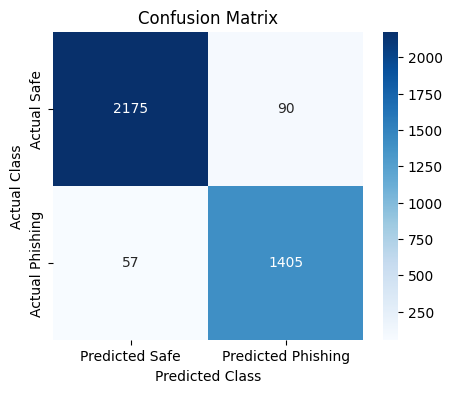

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Phishing'],
            yticklabels=['Actual Safe', 'Actual Phishing'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

The confusion matrix shows only a few mistakes, some phishing emails are still predicted as Safe, but very few.

### Part 5 : Hyperparameter Tuning (Logistic Regression + SVM)
We used GridSearchCV to find the best hyperparameters for Logistic Regression and Linear SVM.

**Hyperparameter tuning for Logistic Regression (GridSearchCV)**  
We used GridSearchCV to find the best possible version of the Logistic Regression model.  
We gave it a “list of possible choices” (called parameter grid) and GridSearch tests all combinations to find the one that predicts best.  

In [13]:
# --- Hyperparameter tuning for Logistic Regression (GridSearchCV) ---

# Base Logistic Regression model (same type as Step 1)
log_reg = LogisticRegression(max_iter=300, n_jobs=-1)

# Parameter grid: we keep it small to avoid long training time
param_grid_lr = {
    "C": [0.1, 1, 10],             # strength of regularization
    "class_weight": [None, "balanced"], # handle class imbalance
    "penalty": ["l2"],            
    "solver": ["lbfgs"]           
}

# GridSearchCV tries all combinations and selects the best one
grid_lr = GridSearchCV(
    estimator=log_reg,           # baseline model
    param_grid=param_grid_lr,    # search space
    scoring="f1",                # focus on F1 score (important for phishing)
    cv=5,                        # 5-fold cross-validation
    n_jobs=-1,                   # use all CPU cores
    verbose=1                    # show progress
)

# Fit grid search on the training data (TF-IDF features)
grid_lr.fit(X_train_tfidf, y_train)

# Extract the best logistic regression model
best_lr = grid_lr.best_estimator_

print("Best LR params:", grid_lr.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best LR params: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


=> GridSearch evaluated 30 models and found that the best model uses C = 10, class_weight = "balanced", L2 regularization, and the lbfgs solver.

**Hyperparameter tuning for Linear SVM (GridSearchCV)**  
An SVM is a classification model that seeks the best possible boundary to separate two classes (Safe Email/Phishing Email). This boundary is a line (in 2D), a plane (in 3D), or a hyperplane (in TF-IDF space).  

The goal is to find a boundary that best separates the two classes while leaving maximum space between them.  
This space = the margin => the larger it is, the more robust the model is.

In [14]:
# --- Hyperparameter tuning for Linear SVM (GridSearchCV) ---

# Baseline SVM model
svm = LinearSVC()

# Parameter grid: only tuning C to keep it fast
param_grid_svm = {
    "C": [0.1, 1, 10]     # regularization strength
}

# Grid search configuration for SVM
grid_svm = GridSearchCV(
    estimator=svm,             # SVM model
    param_grid=param_grid_svm, # grid to search
    scoring="f1",              # F1-score to focus on phishing detection
    cv=5,                      # 5-fold cross validation
    n_jobs=-1,                 # use all CPU cores
    verbose=1                  # show progress
)

# Fit grid search on training features
grid_svm.fit(X_train_tfidf, y_train)

# Extract the best SVM model
best_svm = grid_svm.best_estimator_
print("Best SVM params:", grid_svm.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best SVM params: {'C': 0.1}


GridSearch evaluated 3 SVM configurations (C = 0.1, 1, 10) with 5-fold cross-validation, leading to 15 total fits. The best hyperparameter is C = 1, meaning the model works best with moderate regularization.

### PART 6 : Ensemble Models  

We combine models to improve stability and accuracy using:  
- Voting Classifier (LR + SVM)  
- Bagging with Logistic Regression  


**Voting Classifier**  
The Voting Classifier is an ensemble model => it combines several models and chooses the prediction by majority vote.  

In this case, we combine:    
- Logistic Regression (tuned)  
- SVM (tuned)  
Each model predicts safe or phishing. The Voting Classifier looks at both predictions and chooses the most voted class.

In [27]:
# --- Ensemble model: Voting Classifier (LR + SVM) ---

# Voting classifier (hard voting = majority vote)
voting_clf = VotingClassifier(
    estimators=[
        ("lr", best_lr),     # best logistic regression model
        ("svm", best_svm)    # best SVM model
    ],
    voting="hard"            # choose the class predicted by most models
)

# Train the ensemble model
voting_clf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_vote = voting_clf.predict(X_test_tfidf)

print("Voting Classifier ready")

Voting Classifier ready


**Ensemble model : Bagging**   
Bagging (Bootstrap Aggregating) is an ensemble method that creates multiple versions of the same model and then combines their predictions.  

In our case  :  
- We used 10 Logistic Regression models  
- Each is trained on 80% of the dataset (selected randomly with replacement)  
- The final model makes a prediction based on the average of the 10 results  

In [26]:
# --- Ensemble model: Bagging (using Logistic Regression)---

# Bagging with Logistic Regression
bagging_lr = BaggingClassifier(
    estimator=best_lr,  # reuse the best LR model
    n_estimators=10,         # create 10 models
    max_samples=0.8,         # each model sees 80% of the data
    random_state=42,
    n_jobs=-1                # use all CPU cores
)

# Train the bagging ensemble
bagging_lr.fit(X_train_tfidf, y_train)

# Predictions on test set
y_pred_bag = bagging_lr.predict(X_test_tfidf)


print("Bagging Classifier ready")

Bagging Classifier ready


Why use Bagging?  

=>reduces overfitting  
=>makes predictions more stable  
=>compensates for errors in a single model  
=>useful when a model tends to vary depending on the data  

In our case, Bagging helps stabilize Logistic Regression, but since LR is already very stable on TF-IDF, the improvement is slight, but robustness increases.  

### Part 7: Evaluation of models

`plot_cm()` is a small helper function that draws the confusion matrix as a heatmap.  
The confusion matrix allows us to see:  
- how many emails were correctly classified as Safe  
- how many were correctly classified as Phishing  
- and where the model made mistakes  

It helps visualize model errors and understand where the classifier struggles (false positives, false negatives).

In [19]:
# --- Evaluation of models: classification report + heatmap ---

# ------------------------------------------------------------
# Helper function to display a confusion matrix as a heatmap
# ------------------------------------------------------------
def plot_cm(y_true, y_pred, title):
    """
    Plot confusion matrix for any classifier.
    - y_true: ground-truth labels
    - y_pred: model predictions
    - title: figure title
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred Safe", "Pred Phishing"],
        yticklabels=["True Safe", "True Phishing"]
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

=== Tuned Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2265
           1       0.94      0.97      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



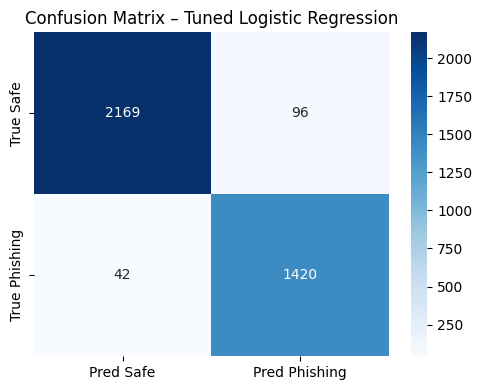

In [20]:
# ------------------------------------------------------------
#  Evaluate Tuned Logistic Regression
# ------------------------------------------------------------
print("=== Tuned Logistic Regression ===")
y_pred_lr = best_lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr))

plot_cm(
    y_test,
    y_pred_lr,
    "Confusion Matrix – Tuned Logistic Regression"
)

=> The tuned Logistic Regression model performs very well:  
- It correctly identifies most phishing emails (97% recall)  
- It also makes very few mistakes on safe emails.  
- Only **96 Safe emails were misclassified as Phishing** (false positives)  
- Only **42 Phishing emails were misclassified as Safe** (false negatives : dangerous type of error)  
- Overall accuracy is 96%, which is strong and balanced. 


=== Tuned Linear SVM ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2265
           1       0.94      0.96      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



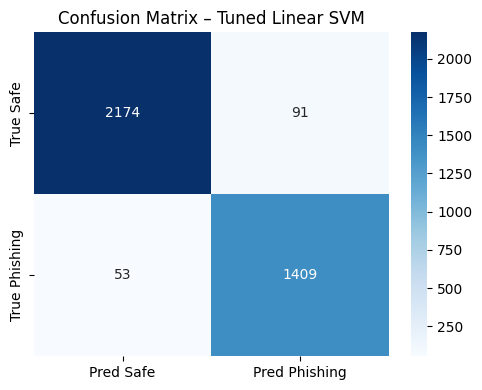

In [21]:
# ------------------------------------------------------------
#  Evaluate Tuned Linear SVM
# ------------------------------------------------------------
print("\n=== Tuned Linear SVM ===")
y_pred_svm = best_svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))

plot_cm(
    y_test,
    y_pred_svm,
    "Confusion Matrix – Tuned Linear SVM"
)


The tuned Linear SVM reaches an accuracy of 96%, very close to the optimized Logistic Regression. It detects phishing emails very well (recall = 0.96), with only 53 missed phishing emails. It still makes some mistakes on Safe emails (91 false alarms), but overall the model remains stable and reliable.


=== Bagging Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2265
           1       0.94      0.97      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



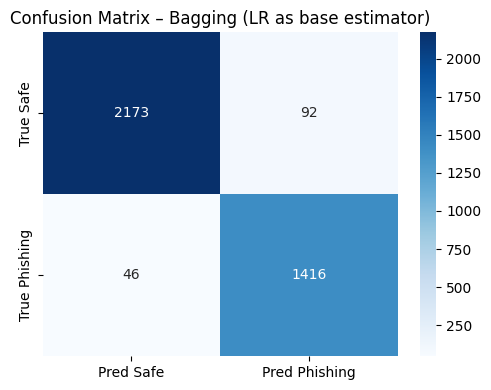

In [23]:
# ------------------------------------------------------------
#  Evaluate Bagging Ensemble (using tuned LR)
# ------------------------------------------------------------
print("\n=== Bagging Ensemble (Logistic Regression) ===")
y_pred_bag = bagging_lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_bag))

plot_cm(
    y_test,
    y_pred_bag,
    "Confusion Matrix – Bagging (LR as base estimator)"
)

The Bagging model built on top of Logistic Regression shows slightly better stability. Overall accuracy stays around 96%, but it reduces the number of errors, especially phishing errors (46 false negatives instead of 92 in the tuned LR).

### Part 8 : Model comparison
In this section, we compute the evaluation metrics for each model (Logistic Regression, Linear SVM, Voting Classifier, and Bagging Classifier).
These metrics will later be used to compare model performance.

In [51]:
# Baseline Logistic Regression Metrics 
acc_baseline   = accuracy_score(y_test, y_pred)
recall_base    = recall_score(y_test, y_pred)
f1_baseline    = f1_score(y_test, y_pred)

# Optimized Logistic Regression
acc_lr = accuracy_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Voting
acc_voting = accuracy_score(y_test, y_pred_vote)
precision_voting = precision_score(y_test, y_pred_vote)
recall_voting = recall_score(y_test, y_pred_vote)
f1_voting = f1_score(y_test, y_pred_vote)

# Bagging
acc_bag = accuracy_score(y_test, y_pred_bag)
recall_bag = recall_score(y_test, y_pred_bag)
f1_bag = f1_score(y_test, y_pred_bag)


In [53]:
# Comparison table
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Baseline Logistic Regression",
        "Optimized Logistic Regression",
        "Linear SVM",
        "Voting Classifier",
        "Bagging Classifier"
    ],
    "Accuracy": [
        acc_baseline, acc_lr, acc_svm, acc_voting, acc_bag
    ],
    "Recall": [
        recall_base, recall_lr, recall_svm, recall_voting, recall_bag
    ],
    "F1-Score": [
        f1_baseline, f1_lr, f1_svm, f1_voting, f1_bag
    ]
})

results


,Model,Accuracy,Recall,F1-Score
0,Baseline Logistic Regression,0.960558,0.961012,0.950287
1,Optimized Logistic Regression,0.962973,0.971272,0.953660
2,Linear SVM,0.961363,0.963748,0.951384
3,Voting Classifier,0.961363,0.959644,0.951186
4,Bagging Classifier,0.962973,0.968536,0.953535


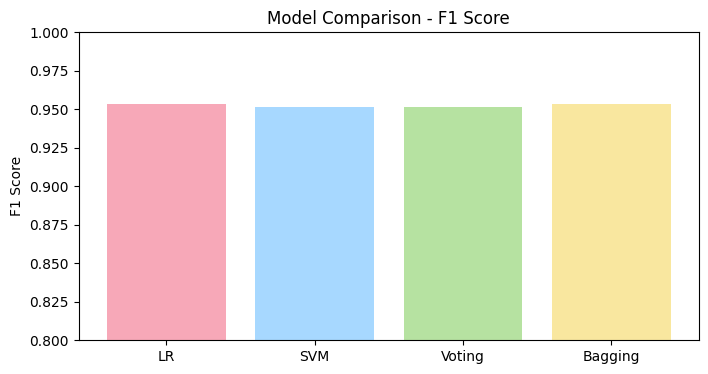

F1 scores:
LR: 0.9536601746138348
SVM: 0.9513841998649561
Voting: 0.9511864406779661
Bagging: 0.9535353535353536


In [50]:
# --- Model comparison (F1-score bar plot) ---

# Compute F1 scores for each model
f1_lr   = f1_score(y_test, y_pred_lr)
f1_svm  = f1_score(y_test, y_pred_svm)
f1_vote = f1_score(y_test, y_pred_vote)
f1_bag  = f1_score(y_test, y_pred_bag)

# List of model names and scores
models = ["LR", "SVM", "Voting", "Bagging"]
scores = [f1_lr, f1_svm, f1_vote, f1_bag]

# Plot
plt.figure(figsize=(8,4))
plt.bar(models, scores, color=["#F7A8B8", "#A7D8FF", "#B6E2A1", "#F9E79F"])
plt.ylim(0.8, 1.0)
plt.title("Model Comparison - F1 Score")
plt.ylabel("F1 Score")
plt.show()

# Print scores for clarity
print("F1 scores:")
print("LR:", f1_lr)
print("SVM:", f1_svm)
print("Voting:", f1_vote)
print("Bagging:", f1_bag)


All the models obtain very similar F1-scores, around 0.95, thay shows that the dataset is quite easy to separate using TF-IDF features.  
Logistic Regression remains one of the best, even after tuning.  
SVM performs almost the same, just slightly lower.  
Voting and Bagging do not bring big improvements, meaning the base models are already very strong.  

In [54]:
best_idx = results['F1-Score'].idxmax()
best_model = results.loc[best_idx, 'Model']
best_f1 = results.loc[best_idx, 'F1-Score']

print("\nBest model:", best_model)
print(f"Best F1-Score: {best_f1:.4f}")



Best model: Optimized Logistic Regression
Best F1-Score: 0.9537


==> So, our best performing model is the optimized Logistic Regression model (after hyperparameter tuning), reaching an F1-score of ~0.953

### Part 9 : Conclusion 

To conclude, our models were able to detect phishing emails very well using only the text of the message. Among all the methods we tested, the optimized Logistic Regression turned out to be the most effective. It had the best balance between accuracy and F1-score.  

This shows that even a simple, well-tuned model can reliably spot phishing attempts and help make email systems safer for users.